# **Asheville AirBnb**

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
!pip install pysal
!pip install geoplot
import pysal
import splot
import re
import seaborn as sns
import folium


# For points map
import geoplot.crs as gcrs
import geoplot as gplt

In [167]:
# Open listings file
listings = pd.read_csv('/content/listings.csv',
                       usecols=['id', 'property_type', 'neighbourhood_cleansed',
                                'bedrooms', 'beds', 'bathrooms_text', 'price',
                                'latitude','longitude'])

# Rename column
listings = listings.rename(columns={'neighbourhood_cleansed':'neighbourhood'}).astype(object)

#listings.columns
listings.sample(4)

id neighbourhood  latitude longitude       property_type  \
1225  38953302         28801  35.59577 -82.55196    Entire townhouse   
1255  39469831         28806  35.57038  -82.5994  Entire guest suite   
140   11947108         28803  35.57818 -82.54402  Entire guest suite   
1113  36573403         28801  35.59878 -82.55587        Entire condo   

     bathrooms_text bedrooms beds    price  
1225      2.5 baths      3.0  4.0  $225.00  
1255         1 bath      1.0  1.0  $117.00  
140          1 bath      2.0  3.0  $142.00  
1113         1 bath      NaN  2.0   $94.00

In [168]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              3239 non-null   object
 1   neighbourhood   3239 non-null   object
 2   latitude        3239 non-null   object
 3   longitude       3239 non-null   object
 4   property_type   3239 non-null   object
 5   bathrooms_text  3238 non-null   object
 6   bedrooms        2768 non-null   object
 7   beds            3211 non-null   object
 8   price           3239 non-null   object
dtypes: object(9)
memory usage: 227.9+ KB


In [169]:
# Filling the NA in the bathroom text variable with zero
listings['bathrooms_text'].fillna('0 bath', inplace=True)

In [170]:
# Correcting the bathroom variable to numeric
listings['bathrooms'] = listings.bathrooms_text.apply(lambda x: re.findall('[\d+]', x)[0] if len(re.findall('[\d+]', x)) > 0 else 0)
listings['bathrooms'] = listings.bathrooms.astype(int)

# Delete bathrooms text
listings.drop('bathrooms_text', axis=1, inplace=True)

In [171]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3239 non-null   object
 1   neighbourhood  3239 non-null   object
 2   latitude       3239 non-null   object
 3   longitude      3239 non-null   object
 4   property_type  3239 non-null   object
 5   bedrooms       2768 non-null   object
 6   beds           3211 non-null   object
 7   price          3239 non-null   object
 8   bathrooms      3239 non-null   int64 
dtypes: int64(1), object(8)
memory usage: 227.9+ KB


In [172]:
# Correct Price to Float (Replace $ and , with nothing)
listings['price'] = (listings['price']
                     .replace("[$,]", "", regex=True)
                     .astype(float)
                     )

In [173]:
# Check if all correct
listings = listings.reindex(columns=str.split('id,neighbourhood,property_type,bedrooms,beds,bathrooms,latitude,longitude,price', sep=','))
listings.head(2)

id neighbourhood       property_type bedrooms beds  bathrooms  \
0   108061         28801  Entire rental unit      1.0  1.0          1   
1  4394761         28801  Entire rental unit      2.0  1.0          1   

   latitude longitude  price  
0   35.6067 -82.55563  100.0  
1  35.61244 -82.55724  114.0

In [174]:
listings.describe(include='all')

id  neighbourhood property_type  bedrooms    beds    bathrooms  \
count     3239.0         3239.0          3239    2768.0  3211.0  3239.000000   
unique    3239.0            8.0            49       9.0    18.0          NaN   
top     108061.0        28806.0   Entire home       1.0     1.0          NaN   
freq         1.0          939.0          1163    1120.0  1134.0          NaN   
mean         NaN            NaN           NaN       NaN     NaN     1.485644   
std          NaN            NaN           NaN       NaN     NaN     0.808976   
min          NaN            NaN           NaN       NaN     NaN     0.000000   
25%          NaN            NaN           NaN       NaN     NaN     1.000000   
50%          NaN            NaN           NaN       NaN     NaN     1.000000   
75%          NaN            NaN           NaN       NaN     NaN     2.000000   
max          NaN            NaN           NaN       NaN     NaN     9.000000   

          latitude   longitude        price  
count   3239.00000  3239.00000  3239.000000  
unique  2849.00000  2908.00000          NaN  
top       35.59524   -82.55219          NaN  
freq      11.00000     9.00000          NaN  
mean           NaN         NaN   179.771843  
std            NaN         NaN   156.068212  
min            NaN         NaN    14.000000  
25%            NaN         NaN    95.000000  
50%            NaN         NaN   135.000000  
75%            NaN         NaN   212.500000  
max            NaN         NaN  2059.000000

### Good insights from descriptive stats:
* 3239 observations
* 49 types of properties to rent in Asheville, NC. Mostly entire homes.
* On average, houses with 2 bedrooms, 1 to 2 bathrooms and $180 dollars.


In [80]:
#price
listings.price.describe()

count    3239.000000
mean      179.771843
std       156.068212
min        14.000000
25%        95.000000
50%       135.000000
75%       212.500000
max      2059.000000
Name: price, dtype: float64

In [91]:
np.quantile(listings['price'], 0.97)

538.3000000000006

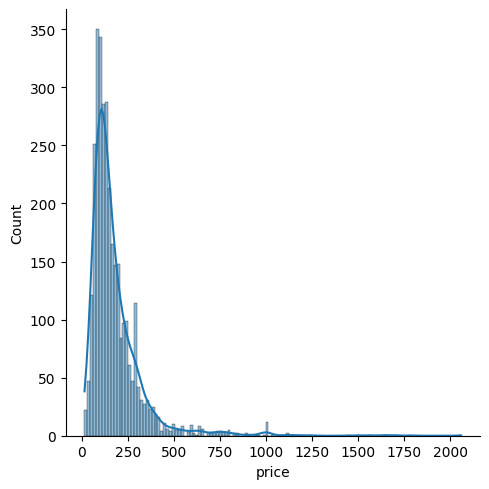

In [10]:
# Check price range
sns.displot(listings['price'], kde=True);

In [11]:
# Convert Pandas df to Geopandas df
listings_gpd = gpd.GeoDataFrame(listings,
                                     geometry=gpd.points_from_xy(listings.longitude, listings.latitude, crs=4326))

In [12]:
# Look at the geometry variable created
listings_gpd.head(2)

id  neighbourhood_cleansed       property_type  bedrooms  beds  \
0   108061                   28801  Entire rental unit       1.0   1.0   
1  4394761                   28801  Entire rental unit       2.0   1.0   

   bathrooms  latitude  longitude  price                    geometry  
0          1  35.60670  -82.55563  100.0  POINT (-82.55563 35.60670)  
1          1  35.61244  -82.55724  114.0  POINT (-82.55724 35.61244)

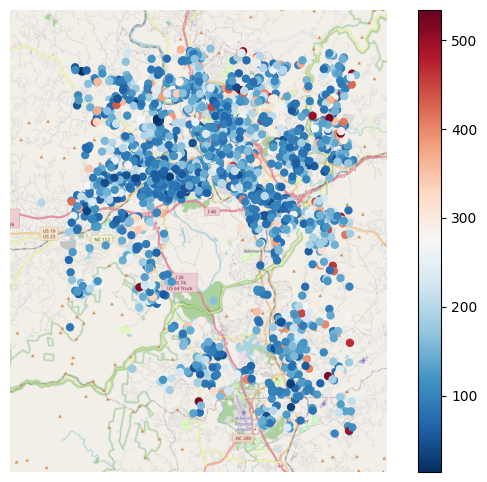

In [99]:
# Points map using geoplot
ax = gplt.webmap(listings_gpd.query('price < 538'), projection=gcrs.WebMercator())
gplt.pointplot(listings_gpd.query('price < 538'), cmap='RdBu_r', ax=ax, hue= 'price', legend=True);

In [151]:
# Reading the Asheville polygon shapefile (geojson)
geofile = '/content/neighbourhoods.geojson'
asheville = gpd.read_file(geofile)
asheville = asheville.to_crs(4326)

In [152]:
asheville.head(3)

neighbourhood  neighbourhood_group  \
0         28806                  NaN   
1         28805                  NaN   
2         28804                  NaN   

                                            geometry  
0  MULTIPOLYGON (((-82.64249 35.55649, -82.64249 ...  
1  MULTIPOLYGON (((-82.43149 35.68162, -82.42569 ...  
2  MULTIPOLYGON (((-82.58466 35.69498, -82.58475 ...

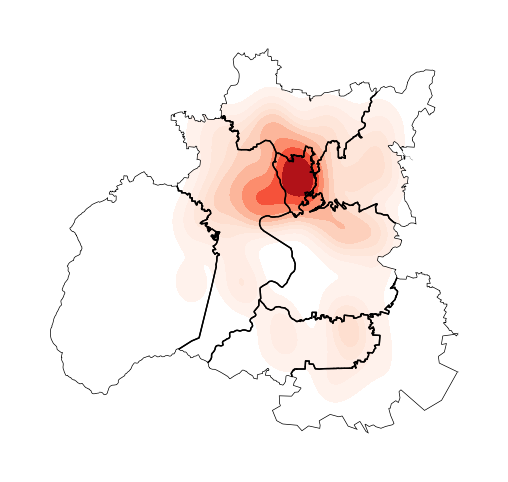

In [153]:
# Heatmap
ax = gplt.kdeplot(listings_gpd,
          fill=True, cmap='Reds',
          clip=asheville.geometry,
          projection=gcrs.WebMercator())

# Plotting the heatmap on top of the geometry
gplt.polyplot(asheville, ax=ax, zorder=1);

### Use folium

In [197]:
from numpy import Inf
# Create clip levels for prices
listings['price_bins']= pd.cut(listings.price,
       bins= [-Inf, 100, 200, 300, 400, 500, Inf],
       labels= ['0-100', '100-200', '200-300', '300-400', '400-500', '500+'])

# Create bin colors
listings['colors'] = listings.price_bins.map({'0-100': 'forestgreen', '100-200':'blue', '200-300':'gold', '300-400':'orange', '400-500':'red', '500+':'black'})
listings.head(2)

id neighbourhood       property_type bedrooms beds  bathrooms  \
0   108061         28801  Entire rental unit      1.0  1.0          1   
1  4394761         28801  Entire rental unit      2.0  1.0          1   

   latitude longitude  price price_bins       colors  
0   35.6067 -82.55563  100.0      0-100  forestgreen  
1  35.61244 -82.55724  114.0    100-200         blue

In [198]:
m = folium.Map(location= [35.5951, -82.5515], zoom_start=10)
for lat, lon, ptcolor in zip(listings.latitude, listings.longitude, listings.colors):
  folium.CircleMarker(
     location=[lat, lon],
     radius=1.5,
     opacity=0.5,
     color=ptcolor,
     fill=True,
     fill_color=ptcolor,
  ).add_to(m)

In [199]:
from folium import plugins

# Preparing data for plot
data = listings[['latitude','longitude', 'price']].values
data =data.tolist()

# Create Heat Map with Folium
hm = plugins.HeatMap(data,gradient={0.1: 'blue', 0.2: 'lime', 0.4: 'yellow', 0.6: 'orange', 0.9: 'red'},
                min_opacity=0.1,
                max_opacity=0.9,
                radius=20,
                use_local_extrema=False)

# Add to base map
hm.add_to(m);

# Display
m

In [201]:
# Add a choropleth layer
folium.Choropleth(
    geo_data=asheville,
    name="choropleth",
    data=listings,
    columns=["neighbourhood", "price"],
    key_on="feature.properties.neighbourhood",
    fill_color="RdBu_r",
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name="Prices",
).add_to(m)
m

In [202]:
m = folium.Map(location= [35.5951, -82.5515], zoom_start=10, tiles="Stamen Terrain")

# Add a choropleth layer to a terrain map
folium.Choropleth(
    geo_data=asheville,
    name="choropleth",
    data=listings,
    columns=["neighbourhood", "price"],
    key_on="feature.properties.neighbourhood",
    fill_color="RdBu_r",
    fill_opacity=0.5,
    line_opacity=0.5,
    legend_name="Prices",
).add_to(m)
m